In [1]:
from omero.gateway import BlitzGateway
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
import pandas as pd
from scipy import ndimage as ndi
from skimage import measure, exposure
from skimage.segmentation import clear_border
from skimage.morphology import remove_small_objects

import cv2

In [6]:
conn = BlitzGateway('hy274', 'omeroreset', host='ome2.hpc.susx.ac.uk')
conn.connect()

False

In [2]:
well_id=[6633,6592,6579,6557,6621,6580,6548,6565,6601,6587,6583,6591,6622,6551,6631,6575,6558,6620,6576,6555,6614,6753,6596,6599,6603,6636,6588,6600,6626,6608,6641,6638,6612,6607,6532,6531,6454,6461,6470,6459,6477,6461,6536,6525,6523,6462,6504,6505,6468,6510,6526,6545,6466,6544,6509,6499,6457,6460,6487,6476,6494,6488,6518,6530,
         6452,6476,6481,6483,6511,6473,6456,6486,6506,6451,6533,6497,6517,6512,6521,6500,6502,6488,6542,6475,6527,6490,6515,6516,6453,6465,6471,6507,6491,6528,6492,6531,6496,6484,6539,6478,6534,6513,6451,6493,6540,6543,6480,6472,6514,6482,6538,6498,6503,6485,6524,6535,6546,6479,6522,6469,6495,6529,6519,6508,6520,6474,
         6463,6455,6501,6458]

In [3]:
def overlay_mask(dapi_mask,cellmask):
    """

    :param dapi_mask:
    :param cellmask:
    :return:
    """
    n_masks=dapi_mask
    masks=cellmask
    overlap=(masks!=0) * (n_masks!=0)
    list_n_masks = np.stack([n_masks[overlap], masks[overlap]])[-2].tolist()
    list_masks = np.stack([n_masks[overlap], masks[overlap]])[-1].tolist()
    overlay_all = {list_n_masks[i]: list_masks[i] for i in range(len(list_n_masks))}
    df = pd.DataFrame(list(overlay_all.items()), columns = ['Nuclei_ID','Cyto_ID'])
    return df

In [4]:
def dna_norm(df):
    """
    :param df:
    :return:
    """

    y, x, _ = plt.hist(df['integrated_int_DAPI'], bins=256)
    max = x[np.where(y == y.max())]
    print(max)
    df['DNA_content'] = df['integrated_int_DAPI'] / max[0]
    return df

In [5]:
def g1_list(df_all):
    return df_all.loc[(df_all['mean_intensity_Edu'] < 950) & (df_all['DNA_content'] < 2),'Nuclei_ID'].tolist()
def s_list(df_all):
    return df_all.loc[df_all['mean_intensity_Edu'] > 1000,'Nuclei_ID'].tolist()
def g2_list(df_all):
    return df_all.loc[(df_all['mean_intensity_Edu'] < 1000) & (df_all['DNA_content'] > 2)& (df_all['mean_intensity_H3'] <20000) ,'Nuclei_ID'].tolist()
def m_list(df_all):
    return df_all.loc[(df_all['mean_intensity_H3'] >20000) & (df_all['DNA_content'] > 2) & (df_all['mean_intensity_Edu'] < 1000),'Nuclei_ID'].tolist()
def Cell_list(df_all,list):
    Cell_list=[]
    for i in list:
        Cell_list.append(df_all.loc[df_all['Nuclei_ID']==i ,'Cyto_ID'].values[0])
    return Cell_list

In [6]:

def nuclei_n_masks(number,n_masks):
    segmented_mask_2=np.zeros(n_masks.shape,dtype=int)
    for i in range(len(number)):
        segmented_mask_2 +=(n_masks*(n_masks==number[i]))
    return segmented_mask_2
def dict_cell_nuclei(nuceli,cyto):
    Dict={}
    for i in range(len(cyto)):
        if cyto[i] not in Dict:
            Dict[cyto[i]]=list()
        Dict[cyto[i]].append(nuceli[i])
    return Dict

In [7]:
def save_data(list_cyto,list_nuclei,ID,masks,n_masks,imgCell,imgDAPI):

    width=32
    if len(list_cyto)==len(list_nuclei):
        for index, (letter, number) in enumerate(dict_cell_nuclei(list_nuclei,list_cyto).items()):


            segmented_1=(masks*(masks==letter))
            segmented_2=nuclei_n_masks(number=number,n_masks=n_masks)
            if len(measure.regionprops(segmented_1))!=0 and len(measure.regionprops(segmented_2))!=0:

                region_1=measure.regionprops(segmented_1)[0]
                region_2=measure.regionprops(segmented_2)[0]
                b_1=imgCell[region_1.bbox[0]:region_1.bbox[2],region_1.bbox[1]:region_1.bbox[3]]
                b_2=imgDAPI[region_2.bbox[0]:region_2.bbox[2],region_2.bbox[1]:region_2.bbox[3]]
    # a=(masks*(masks==id))[region.bbox[0]:region.bbox[2],region.bbox[1]:region.bbox[3]]
    # c=(a!=0)*b
    # plt.imshow(a)
    # plt.show()
                if (10 <= len(b_1) <= 100) and (10 <= len(b_2) <= 100):
                    centroid=region_1.centroid


    # plt.imshow(b)
    # plt.show()

                    i = centroid[0]
                    j = centroid[1]
                    imin = int(round(max(0, i-width)))
                    imax = int(round(min(masks.shape[0], i+width)))
                    jmin = int(round(max(0, j-width)))
                    jmax = int(round(min(masks.shape[1], j+width)))
                    box_mask_1=segmented_1[imin:imax, jmin:jmax]
                    box_mask_1=(box_mask_1!=0)*np.ones_like(box_mask_1)
                    # box_img_1=imgCell[imin:imax, jmin:jmax]
                    # box_1=(box_mask_1!=0)*box_img_1

                    box_mask_2=segmented_2[imin:imax, jmin:jmax]
                    box_mask_2=(box_mask_2!=0)*np.ones_like(box_mask_2)
                    # box_img_2=imgDAPI[imin:imax, jmin:jmax]
                    # box_2=(box_mask_2!=0)*box_img_2

                    # print(box_1.shape[0],box_1.shape[1])
                    # print(box_2.shape[0],box_2.shape[1])
                    if box_mask_1.shape[0]==box_mask_2.shape[0] and box_mask_1.shape[1]==box_mask_2.shape[1]:


                        # cv2.imwrite('/Users/Lab/Documents/RPE-1_10000_Flatfield_Corr_814/image_alpha_tubulins/'+str(int(ID))+'_'+str(int(letter))+'.tif',box_img_1,)
                        # cv2.imwrite('/Users/Lab/Documents/RPE-1_10000_Flatfield_Corr_814/image_DAPI/' +str(int(ID))+'_'+str(int(letter))+'.tif',box_img_2)
                        cv2.imwrite('/Users/Lab/Documents/RPE-1_10000_Flatfield_Corr_814/boolean_mask_tubuliins/'+str(int(ID))+'_'+str(int(letter))+'.tif',box_mask_1,)
                        cv2.imwrite('/Users/Lab/Documents/RPE-1_10000_Flatfield_Corr_814/boolean_nuclei/' +str(int(ID))+'_'+str(int(letter))+'.tif',box_mask_2)


[1172055.68645289]
[1132347.51441723]
[1056017.84691948]
[1145102.87898171]
[1088706.92093292]
[1141098.19615999]
[1185771.24094294]
[1115551.69978572]
[1155409.38887473]
[1086173.49896085]
[1057073.74310215]
[1191033.88748692]
[1016810.54802362]
[1136004.22464823]
[1107922.38738727]
[1208965.67351541]
[1026430.46223922]
[1026000.15720502]
[1139478.59559241]
[1026011.80649461 1067676.84858691]
[1086283.22327278 1126649.44820859]
[1096717.38397629]
[1076633.23275745]
[1191403.27511324]
[1255760.74205145]
[1115637.57920536]
[1179884.4950603]
[1106878.21631187]
[1124250.30678431 1168817.06749878]
[1122078.00828935]
[1099354.18943769 1164212.83021318]
[1022834.8492816  1077467.06764765]
[1067624.12944971]
[1159684.08288524]
[1109036.98058788]
[1139500.65509917]
[1057847.21098805]
[1135525.63905505]
[1170304.58380736]
[1096315.70958536]
[1114201.19446331]
[1106616.26314724]
[1107575.45377211]
[1110521.76091605]
[1177551.98476657]
[1168231.87253265]
[1088919.00014276]
[1091092.48592113]
[117

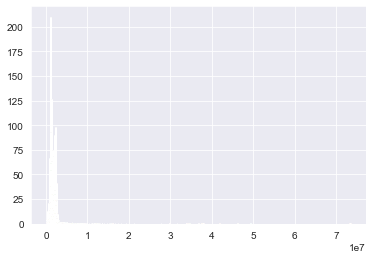

In [8]:
from numpy import asarray
from PIL import Image
import pandas as pd
import os
import numpy as np
import skimage
path_1='/Users/Lab/Documents/RPE-1_10000_Flatfield_Corr_814/merge_channels_2/'
path_DAPI='/Users/Lab/Documents/RPE-1_10000_Flatfield_Corr_814/0'
path_Edu='/Users/Lab/Documents/RPE-1_10000_Flatfield_Corr_814/1'
path_H3='/Users/Lab/Documents/RPE-1_10000_Flatfield_Corr_814/2'
path_cell='/Users/Lab/Documents/RPE-1_10000_Flatfield_Corr_814/3'
list_dir_cell=os.listdir(path_1)
# list_dir_cell.remove('.DS_Store')
Feature_list=['label','area','max_intensity','mean_intensity']
df_final=pd.DataFrame()
# plateId=813
df_cell_phase=pd.DataFrame()
df_label=pd.DataFrame()
for i in list_dir_cell:

    image1 = skimage.io.imread(os.path.join(path_1,i))


    imageDAPI = skimage.io.imread(os.path.join(path_DAPI,i))
        # imageDAPI=Image.fromarray(imageDAPI * 255).convert('L')
        # imageDAPI=np.array(imageDAPI)

    imageEdu = skimage.io.imread(os.path.join(path_Edu,i))
        # imageEdu=Image.fromarray(imageEdu * 255).convert('L')
        # imageEdu=np.array(imageEdu)

    imageH3 = skimage.io.imread(os.path.join(path_H3,i))
        # imageH3=Image.fromarray(imageH3 * 255).convert('L')
        # imageH3=np.array(imageH3)

    imageCell = skimage.io.imread(os.path.join(path_cell,i))
        # imageCell=Image.fromarray(imageCell * 255).convert('L')
        # imageCell=np.array(imageCell)

    img=np.stack((imageDAPI,imageCell,imageEdu,imageH3),axis=2)
         #modle
    cyto2_tubulin_model_path='/Users/Lab/PycharmProjects/Omero_Screen/data/CellPose_models/RPE-1_Tub_Hoechst'
    model = models.CellposeModel(gpu=True, pretrained_model=cyto2_tubulin_model_path)
    channels = [2,3]
    masks, flows, styles = model.eval(image1, diameter=30.8, channels=channels)
    nuclei_DAPI_model_path='/Users/Lab/PycharmProjects/Omero_Screen/data/CellPose_models/Nuclei_Hoechst'
    n_model = models.CellposeModel(gpu=True, pretrained_model=nuclei_DAPI_model_path)
    n_channels = [3,0]
    n_masks, n_flows, n_styles = n_model.eval(imageDAPI, diameter=15, channels=n_channels)
        #
        #
        #
        # 4 type cell cycle
    df_overlay=overlay_mask(dapi_mask=n_masks,cellmask=masks)
    df_cell_cycle=measure.regionprops_table(n_masks, img, properties=Feature_list )
    df_cell_cycle=pd.DataFrame(df_cell_cycle)

    df_cell_cycle.columns=['Nuclei_ID','area', 'max_intensity_DAPI', 'max_intensity_Tub', 'max_intensity_Edu','max_intensity_H3','mean_intensity_DAPI','mean_intensity_Tub','mean_intensity_Edu', 'mean_intensity_H3']

    df_result = pd.merge(df_cell_cycle, df_overlay, how="outer", on=["Nuclei_ID"])
    df_result['integrated_int_DAPI']=df_result['mean_intensity_DAPI']*df_result['area']

    df_result['Image_ID']= i[:6]
    df_gn = dna_norm(df_result)
    df_gn = df_gn.dropna()
    Nuclei_list=df_gn['Nuclei_ID'].tolist()
        # Nuclei_list = [x for x in Nuclei_list if np.isnan(x) == False]
    cell_list=Cell_list(df_gn,Nuclei_list)
    save_data(list_nuclei=Nuclei_list,list_cyto=cell_list,ID=i[:6],masks=masks,n_masks=n_masks,imgCell=imageCell,imgDAPI=imageDAPI)
    df_final=pd.concat([df_final,df_gn])


In [9]:
df_final.to_csv('/Users/Lab/Documents/RPE-1_10000_Flatfield_Corr_814/df_final_boolean.csv')

In [10]:
df_final

,Nuclei_ID,area,max_intensity_DAPI,max_intensity_Tub,max_intensity_Edu,max_intensity_H3,mean_intensity_DAPI,mean_intensity_Tub,mean_intensity_Edu,mean_intensity_H3,Cyto_ID,integrated_int_DAPI,Image_ID,DNA_content
0,1,90,17967.633889,14690.764372,5197.736679,4909.906725,12775.372181,9432.533044,2000.730585,4580.963627,3.0,1.149783e+06,309419,0.980997
1,2,146,18736.947726,22299.115660,887.042388,4891.308835,12918.785545,9691.977412,725.241859,4531.214288,5.0,1.886143e+06,309419,1.609260
2,3,103,14105.099552,22912.931139,867.030490,4968.515023,10105.357488,12103.931707,722.389677,4547.658277,7.0,1.040852e+06,309419,0.888057
3,4,182,15386.235042,18129.965099,999.686844,5193.269456,11048.197181,9318.316876,777.938247,4671.004318,2.0,2.010772e+06,309419,1.715594
4,5,103,11389.954928,17249.917232,3531.245917,5145.504265,9031.524071,9161.326933,2412.317588,4744.002380,1.0,9.302470e+05,309419,0.793688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,574,134,12306.583871,10876.528955,16848.359661,4517.158294,9530.608247,6769.695001,12131.974597,4195.591860,556.0,1.277102e+06,310145,1.223323
574,575,89,16535.905031,9025.968992,779.093592,4339.274111,12212.394861,5891.828581,679.434922,4015.095613,550.0,1.086903e+06,310145,1.041134
575,576,44,14466.607677,11597.247446,17139.542846,4460.505515,10636.843211,7275.965598,12497.329783,4188.007664,551.0,4.680211e+05,310145,0.448313
576,577,30,10093.007708,10668.544915,923.535060,4164.569889,7471.221270,7741.675359,783.467190,3928.172615,557.0,2.241366e+05,310145,0.214698


In [11]:
df_final.loc[(df_final['Image_ID']=='308896')]


,Nuclei_ID,area,max_intensity_DAPI,max_intensity_Tub,max_intensity_Edu,max_intensity_H3,mean_intensity_DAPI,mean_intensity_Tub,mean_intensity_Edu,mean_intensity_H3,Cyto_ID,integrated_int_DAPI,Image_ID,DNA_content
0,1,115,19906.486308,16072.154944,8678.686819,4585.984530,15572.723813,9552.962571,5034.425921,4244.107095,4.0,1.790863e+06,308896,1.589591
1,2,168,14949.220982,22364.254556,861.160838,4559.393652,10771.469287,11141.442754,725.973837,4162.882716,2.0,1.809607e+06,308896,1.606228
2,3,62,22248.437248,17041.343308,816.923934,4818.361963,16010.123056,10694.610089,725.532551,4388.325353,5.0,9.926276e+05,308896,0.881068
3,4,118,11756.272152,16336.284269,848.289896,4600.768015,9125.754768,8825.575746,704.697312,4119.725122,6.0,1.076839e+06,308896,0.955815
4,5,80,17354.652396,15932.494409,787.488299,4717.282501,13138.857850,9552.583085,705.311652,4342.223694,11.0,1.051109e+06,308896,0.932976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,464,159,26226.964822,23959.475706,1052.425539,5982.342367,18446.673317,10804.261637,793.008858,4958.651641,477.0,2.933021e+06,308896,2.603383
464,465,68,25183.159567,17103.262650,33872.788728,4861.297613,18167.084682,12195.586619,17730.517218,4407.552498,481.0,1.235362e+06,308896,1.096521
465,466,79,21504.779762,12887.457500,26633.829492,4601.213853,15681.237220,8420.356309,11693.359035,4202.099762,482.0,1.238818e+06,308896,1.099589
466,467,47,15233.565876,12562.041390,16733.568893,4321.836918,11240.636407,6904.902805,11967.657818,4060.171305,475.0,5.283099e+05,308896,0.468934


In [11]:
df_final.to_csv('/Users/haoranyue/Documents/master_project/df_aggregator_10_25.csv')

In [ ]:

conn = BlitzGateway('hy274', 'omeroreset', host='ome2.hpc.susx.ac.uk')

In [ ]:
from numpy import asarray
from PIL import Image
import pandas as pd
Feature_list=['label','area','max_intensity','mean_intensity']
df_final=pd.DataFrame()
# plateId=813
df_cell_phase=pd.DataFrame()
df_label=pd.DataFrame()
well_id=[6462,6504,6505,6468,6510,6526,6545,6466,6544,6509,6499,6457,6460,6487,6476,6494,6488,6518,6530]
for ic,ind in enumerate(well_id):
    print(ic)
    WellID = ind
    well = conn.getObject("Well", WellID)
    conn = BlitzGateway('hy274', 'omeroreset', host='ome2.hpc.susx.ac.uk')
    conn.connect()
    for index, image in enumerate(well.listChildren()):
        image = well.getImage(index)

        id_img=well.getImage(index).getId()
        pixels=image.getPrimaryPixels()
        imgall=image.renderImage(image.getSizeZ()/2,0)
        img_array=np.array(imgall)
        imgDAPI=pixels.getPlane(0,0,0)
        imgCell=pixels.getPlane(0,3,0)
        imgEdu=pixels.getPlane(0,1,0)
        imgH3=pixels.getPlane(0,2,0)
        img=np.stack((imgDAPI,imgCell,imgEdu,imgH3),axis=2)
        print(imgDAPI)
        # DAPI=aggregator_image(imgDAPI,norm_image_CH0)
        # CEll=aggregator_image(imgCell,norm_image_CH3)
        # Edu=aggregator_image(imgEdu,norm_image_CH1)
        # H3=aggregator_image(imgH3,norm_image_CH2)
        # cv2.imwrite('/Users/haoranyue/Documents/master_project/output_DAPI/'+str(int(id_img))+'.tif',DAPI)
        # cv2.imwrite('/Users/haoranyue/Documents/master_project/output_cell/'+str(int(id_img))+'.tif',CEll)
        # cv2.imwrite('/Users/haoranyue/Documents/master_project/output_Edu/' +str(int(id_img))+'.tif',Edu)
        # cv2.imwrite('/Users/haoranyue/Documents/master_project/output_H3/' +str(int(id_img))+'.tif',H3)

        # plt.imshow(CEll)





            # min = img.min()
            # percentiles = np.percentile(img, (2, 98))
            # scaled = exposure.rescale_intensity(img, in_range=tuple(percentiles))
            # corr_img = img / norm_image_CH0
            # corr_scaled = exposure.rescale_intensity(corr_img, in_range=tuple(percentiles))
            # fig, ax = plt.subplots(ncols=4, figsize=(16, 5))
            # plt.sca(ax[0])
            # plt.imshow(scaled, cmap='gray')
            # plt.title(f"{image.getId()} Channel {0}")
            # plt.sca(ax[1])
            # diag = np.diagonal(img)
            # plt.plot(range(len(diag)), diag)
            # plt.ylim(min,5*min)
            # plt.sca(ax[2])
            # plt.imshow(corr_scaled, cmap='gray')
            # plt.title(f"{image.getId()} Channel {0} flatfield corrected")
            # plt.sca(ax[3])
            # bg_diag = np.diagonal(img/norm_image_CH0)
            # plt.plot(range(len(bg_diag)), bg_diag)
            # plt.ylim(min, 5*min)
            # # save_fig(path, f"Channel{channel}_Flatfield_correction")
            # plt.show()




        #  #modle
        # cyto2_tubulin_model_path='/Users/haoranyue/Documents/master_project/parpers/RPE-1_Tub_Hoechst'
        # model = models.CellposeModel(gpu=False, pretrained_model=cyto2_tubulin_model_path)
        # channels = [2,3]
        # masks, flows, styles = model.eval(img_array, diameter=30.8, channels=channels)
        # nuclei_DAPI_model_path='/Users/haoranyue/PycharmProjects/pythonProject/DPAI_813/models/nuclei_DAPI'
        # n_model = models.CellposeModel(gpu=False, pretrained_model=nuclei_DAPI_model_path)

        # n_model = models.CellposeModel(gpu=False, model_type = 'nuclei')
        # n_channels = [3,0]
        # n_masks, n_flows, n_styles = n_model.eval(imgDAPI, diameter=15, channels=n_channels)



        # 4 type cell cycle
        # df_overlay=overlay_mask(dapi_mask=n_masks,cellmask=masks)
        # df_cell_cycle=measure.regionprops_table(n_masks, img, properties=Feature_list )
        # df_cell_cycle=pd.DataFrame(df_cell_cycle)
        # df_cell_cycle.columns=['Nuclei_ID','area', 'max_intensity_DAPI', 'max_intensity_Tub', 'max_intensity_Edu','max_intensity_H3','mean_intensity_DAPI','mean_intensity_Tub','mean_intensity_Edu', 'mean_intensity_H3']
        #
        # df_result = pd.merge(df_cell_cycle, df_overlay, how="outer", on=["Nuclei_ID"])
        # df_result['integrated_int_DAPI']=df_result['mean_intensity_DAPI']*df_result['area']
        #
        # df_result['Image_ID']= image.getId()
        # df_gn = dna_norm(df_result)
        # Nuclei_list=df_gn['Nuclei_ID'].tolist()
        # Nuclei_list = [x for x in Nuclei_list if np.isnan(x) == False]
        # cell_list=Cell_list(df_gn,Nuclei_list)
        # save_data(list_nuclei=Nuclei_list,list_cyto=cell_list,ID=id_img)
        #
        # df_final=pd.concat([df_final,df_gn])
        #


        # df_cell_phase=pd.concat([df_gn,df_cell_phase])
        # #
        #
        # G1_list=g1_list(df_gn)
        # G1_list = [x for x in G1_list if np.isnan(x) == False]
        # S_list=s_list(df_gn)
        # S_list = [x for x in S_list if np.isnan(x) == False]
        # G2_list=g2_list(df_gn)
        # G2_list = [x for x in G2_list if np.isnan(x) == False]
        # M_list=m_list(df_gn)
        # M_list = [x for x in M_list if np.isnan(x) == False]

        # cell_list_g1=Cell_list(df_gn,G1_list)
        #
        # cell_list_s=Cell_list(df_gn,S_list)
        # cell_list_g2=Cell_list(df_gn,G2_list)
        # cell_list_m=Cell_list(df_gn,M_list)

        # #
        # save_data_label_g1(list_nuclei=G1_list,list_cyto=cell_list_g1,ID=id_img)
        # save_data_label_s(list_nuclei=S_list,list_cyto=cell_list_s,ID=id_img)
        # save_data_label_g2(list_nuclei=G2_list,list_cyto=cell_list_g2,ID=id_img)
        # save_data_label_m(list_nuclei=M_list,list_cyto=cell_list_m,ID=id_img)

#
#         df_label=pd.concat([df_g1,df_s,df_g2,df_M,df_result])
#
#
# df_label.head()


In [ ]:
df_final

In [ ]:
df_1=df_final
df_1

In [ ]:
df_final=df_final.reset_index()

In [ ]:
df_final

In [ ]:
df_final.to_csv('/Users/haoranyue/Documents/master_project/df_check_10_12.csv')


In [ ]:
import pandas as pd
df_112=pd.read_csv('/Users/haoranyue/Documents/master_project/df_check_09_14.csv')

In [ ]:
df_112

In [ ]:
df_112
df_label.loc[df_label['img_object'].str.contains('G1'), 'target'] = str(int(0))
df_label.loc[df_label['img_object'].str.contains('S'), 'target'] = str(int(1))
df_label.loc[df_label['img_object'].str.contains('G2'), 'target'] = str(int(2))
df_label.loc[df_label['img_object'].str.contains('M'), 'target'] = str(int(3))


In [ ]:
df_112.loc[ (df_112['mean_intensity_Edu'] < 1000) & (df_112['DNA_content'] < 2),'lable']='G1'
df_112.loc[df_112['mean_intensity_Edu'] > 1000,'lable']='S'
df_112.loc[(df_112['mean_intensity_Edu'] < 1000) & (df_112['DNA_content'] > 2)& (df_112['mean_intensity_H3'] <20000),'lable']='G2'
df_112.loc[(df_112['mean_intensity_H3'] >20000) & (df_112['DNA_content'] > 2) & (df_112['mean_intensity_Edu'] < 1000),'lable']='M'


In [ ]:
df_112.to_csv('/Users/haoranyue/Documents/master_project/df_threshold_2.csv')

In [ ]:
def g1_list(df_all):
    return df_all.loc[(df_all['mean_intensity_Edu'] < 1000) & (df_all['DNA_content'] < 2),'Nuclei_ID'].tolist()
def s_list(df_all):
    return df_all.loc[df_all['mean_intensity_Edu'] > 1000,'Nuclei_ID'].tolist()
def g2_list(df_all):
    return df_all.loc[(df_all['mean_intensity_Edu'] < 1000) & (df_all['DNA_content'] > 2)& (df_all['mean_intensity_H3'] <20000) ,'Nuclei_ID'].tolist()
def m_list(df_all):
    return df_all.loc[(df_all['mean_intensity_H3'] >20000) & (df_all['DNA_content'] > 2) & (df_all['mean_intensity_Edu'] < 1000),'Nuclei_ID'].tolist()

In [ ]:
# library & dataset
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(style='ticks', font='Arial')
fig, ax = plt.subplots(figsize=(8, 8))
# Use the 'palette' argument
sns.scatterplot( x="DNA_content", y="mean_intensity_Edu", data=df_112,  hue='lable', legend=True,palette=['blue','green','yellow','red'], )
ax.set_yscale('log')
# Move the legend to an empty part of the plot
ax.axhline(y=950,color="red",)
ax.axhline(y=3000, color="red",)
ax.axvline(x=2,c='red',ymin = 0, ymax = 0.24 )
plt.legend(loc='lower right')
plt.xlim(0, 8)
plt.show()

In [ ]:
import seaborn as sns

plt.figure(figsize=(15, 15))
plt.scatter(df_112.loc[df_112['lable']=='S','DNA_content'],df_112.loc[df_112['lable']=='S','mean_intensity_Edu'])
# plt.scatter(df_gn['DNA_content'],df_gn['mean_intensity_H3'])
# plt.scatter(df_112.loc[df_112['mean_intensity_H3']>20000,'DNA_content'],df_112.loc[df_112['mean_intensity_H3']>20000,'mean_intensity_Edu'])
plt.axhline(y=1000, color ="red", )
# plt.xlabel('DNA_content',fontsize=8)
# plt.ylabel('mean_intensity_EdU',fontsize=8)
# plt.axhline(y=20000, color="red",)
plt.yscale('log')

plt.axhline(y=1000, color="red",)
# plt.axvline(x=1.5,c='red',ymin = 0, ymax = 0.24 )
#
# plt.axvline(x=2,c='red',ymin = 0, ymax = 0.24 )
plt.ylabel('Mean_intensity_EdU',fontdict={'fontsize':24})
plt.xlabel('DNA_content',fontdict={'fontsize':24})
plt.title('S phase',fontdict={'fontsize':24})
plt.show()


In [2]:
traing=[0.8809904307141344,

0.8451393033867955,

0.765446598763887,

0.8879219053853707,

0.8773128983191174,

0.883608987812157,

0.889269692127,

0.8904827001944664,

0.8830121108265784,

0.8865163563548145,

0.8601960067004255,

0.897009838843214,

0.8820494060111289,


0.887479061170264,

0.8955465275237307,

0.8888653561045112,

0.8947378554787531,

0.8967017733022701,

0.8463908196468799,

0.8566725070758804,

0.8551129252748523,

0.8655678995706336,

0.8919460115139496,


0.8827040452856345,



0.8939869457227025,



0.8665113502897741,



0.8900976182682866,



0.8644704160810213,



0.8984346419700792,



0.8979917977549724,



0.8015865375358607,



0.894949650538152,



0.8785644145792018,



0.898781215703641,



0.8994358549781466,



0.8586749330920154,



0.885515143346747,



0.8878833971927528,



0.8868629300883764,



0.763655967807151,



0.8932937982555789,



0.8909833066985001,



0.8683789976317462,


0.8841481025088087,



0.8974334289620116,


0.872518628338179,


0.8670312108901169,



0.8899050773051966,



0.8951999537901688,



0.8791805456610894,



0.8165469703679458,



0.8843021352792807,



0.8597146542927008,



0.8751949477251285,



0.8910218148911181,



0.8488360898781215,


0.893139765485107,



0.9023432235208041,



0.8965862487244162,



0.891118085372663,



0.8995128713633825,



0.8956620521015846,



0.8735583495388644,


0.8795078652983422,



0.8958738471609835,



0.8959508635462194,



0.8898088068236517,



0.8926969212700002,



0.8847834876870054,


0.8518782370949419,



0.8972601420952308,



0.8908677821206462,



0.8963166913760903,



0.9000134778674163,



0.8864008317769605,


0.8974911912509387,


0.887517569362882,



0.900494830275141,



0.8907522575427922,



0.8548818761191443,



0.9029015923137648,



0.8625064982575043,



0.8956620521015846,



0.8717484644858193,



0.902478002194967,



0.8939291834337756,




0.8991085353408937,



0.900456322082523,



0.8884995282746404,



0.8827618075745615,



0.8837245123900109,



0.8947956177676801,



0.8788724801201455,



0.8847449794943875,



0.9012264859348826,



0.876196160733196,



0.86296859656892,



0.8999172073858713,



0.8956620521015846,



0.9088318539769336,



0.8982998632959162,



0.9048077478483547,



0.9022276989429501,



0.8657796946300326,



0.900417813889905,



0.8812022257735334,



0.9032289119510176,



0.8776209638600613,



0.8964899782428711,



0.9028630841211468,



0.9058859772416582,



0.9025935267728209,



0.9030941332768546,



0.9110268209561584,



0.9046152068852649,



0.9062325509752199,



0.9074840672353043,



0.9003407975046691,



0.9092746981920403,



0.9083505015692088,




0.9077536245836302,




0.9103336734890348,




0.9110460750524674,



0.9032096578547086,

]

In [4]:
len(traing)


124

In [6]:
test=[


0.8855602618405853,

0.8425105891413169,

0.7637273777435503,

0.8921062764728533,

0.8807085098190219,

0.8826338082402773,

0.8912591451675009,

0.8931844435887563,

0.8821717366191759,

0.8909510974201001,

0.8586830958798614,

0.8974971120523682,

0.8820494060111289,
0.8802464381979207,

0.8917982287254524,

0.8972660762418175,

0.8910281093569503,

0.8957258375048133,

0.8981132075471698,

0.844358875625722,

0.859992298806315,

0.8585290720061609,

0.8703889102810936,

0.8955718136311128,

0.8813246053138236,


0.8965729688101656,


0.86907970735464,


0.8907200616095495,


0.8683095879861379,


0.9002695417789758,

0.8991143627262226,


0.8080862533692722,


0.8961879091259145,


0.8827878321139777,


0.8983442433577205,


0.9008856372737775,

0.8653831343858298,


0.8854062379668849,


0.8879476318829419,



0.8909510974201001,

0.7702733923758183,


0.8954948016942627,


0.8887177512514439,


0.8730073161340007,

0.8877165960723912,


0.9005005775895264,


0.8762418174817097,


0.8716211012706969,

0.8927993839045052,


0.8960338852522141,

0.8831728917982288,


0.8209472468232576,

0.8871005005775895,


0.8663842895648826,


0.8802464381979207,


0.8907970735463997,

0.8545244512899499,


0.8952637658837119,


0.902887947631883,


0.8973430881786677,

0.8917982287254524,


0.8991913746630728,


0.8958798613785137,
0.8770119368502118,


0.8830958798613785,


0.895648825567963,

0.896726992683866,


0.8936465152098575,


0.8932614555256064,


0.885791297651136,

0.8554485945321525,

0.8974201001155179,


0.8926453600308047,

0.8971890643049673,


0.8993453985367732,


0.8882556796303427,


0.8994994224104736,

0.8882556796303427,


0.9014247208317289,


0.8911051212938005,


0.858914131690412,

0.9001155179052753,

0.8661532537543319,


0.8968040046207162,

0.875625721986908,


0.9026569118213323,


0.8941085868309588,


0.8988063149788217,


0.9015017327685791,


0.8887947631882942,


0.8835579514824797,

0.8864844050827878,


0.8941085868309588,

0.8820177127454756,


0.8804004620716211,


0.9030419715055834,

0.8797843665768194,


0.865845206006931,

0.9008856372737775,

0.8974971120523682,


0.9084328070850982,


0.8970350404312668,


0.9018867924528302,


0.9022718521370813,


0.868694647670389,


0.902194840200231,


0.8840970350404312,

0.902887947631883,


0.8799383904505198,


0.8991143627262226,


0.9021178282633808,


0.9048902579899885,


0.9018867924528302,


0.9011936850211782,

0.9097420100115517,


0.9025798998844821,


0.9076626877165961,


0.9041201386214863,

0.8994994224104736,

0.9069695802849441,


0.9052753176742395,



0.9065075086638429,



0.9086638428956488,



0.9086638428956488,



0.9001925298421255,



]

In [7]:
test


[0.8855602618405853,
 0.8425105891413169,
 0.7637273777435503,
 0.8921062764728533,
 0.8807085098190219,
 0.8826338082402773,
 0.8912591451675009,
 0.8931844435887563,
 0.8821717366191759,
 0.8909510974201001,
 0.8586830958798614,
 0.8974971120523682,
 0.8820494060111289,
 0.8802464381979207,
 0.8917982287254524,
 0.8972660762418175,
 0.8910281093569503,
 0.8957258375048133,
 0.8981132075471698,
 0.844358875625722,
 0.859992298806315,
 0.8585290720061609,
 0.8703889102810936,
 0.8955718136311128,
 0.8813246053138236,
 0.8965729688101656,
 0.86907970735464,
 0.8907200616095495,
 0.8683095879861379,
 0.9002695417789758,
 0.8991143627262226,
 0.8080862533692722,
 0.8961879091259145,
 0.8827878321139777,
 0.8983442433577205,
 0.9008856372737775,
 0.8653831343858298,
 0.8854062379668849,
 0.8879476318829419,
 0.8909510974201001,
 0.7702733923758183,
 0.8954948016942627,
 0.8887177512514439,
 0.8730073161340007,
 0.8877165960723912,
 0.9005005775895264,
 0.8762418174817097,
 0.87162110127069

In [9]:
import pandas as pd
df_train=pd.DataFrame(traing,columns=['train'])
df_test=pd.DataFrame(test,columns=['test'])
df_train.to_csv('/Users/haoranyue/Documents/master_project/disseration_image/accuracy_epoch/epoch_CNN_16_11_train.csv')
df_test.to_csv('/Users/haoranyue/Documents/master_project/disseration_image/accuracy_epoch/epoch_CNN_16_11_test.csv')

In [ ]:
x = df_1['Unnamed: 0'] + 1
x
x2 = df_2['Unnamed: 0'] + 1
x2

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
# line 1 points
y1 = df_1['train_accuracy']
x1 = x
# plotting the line 1 points
plt.plot(x1, y1, label = "train")

# line 2 points
x2 =x2
y2 = df_2['test_accuracy']
# plotting the line 2 points
plt.plot(x2, y2, label = "test")


# line 3 points
# x3 = x
# y3 = df_3['loss']
# plotting the line 2 points
# plt.plot(x3, y3, label = "loss")

# line 4 points
# x4 = x
# y4 = df_4['loss']
# plotting the line 2 points
# plt.plot(x4, y4, label = "ResNet101")

# naming the x axis
plt.xlabel('epoch')
# naming the y axis
plt.ylabel('accuracy')
# giving a title to my graph
plt.title('accuracy on train epoch')

# show a legend on the plot
plt.legend()

# function to show the plot
plt.show()
